In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn import metrics
import lightgbm as lgb

sys.path.append('../')
from pipelines import main
import pipeline_config as cfg

EXPERIMENT_DIR = 'YOUR/PATH/TO/EXPERIMETS'

neptune: Executing in Offline Mode.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Solution 1

Local CV: **0.2278**
Public LB: **0.2351**

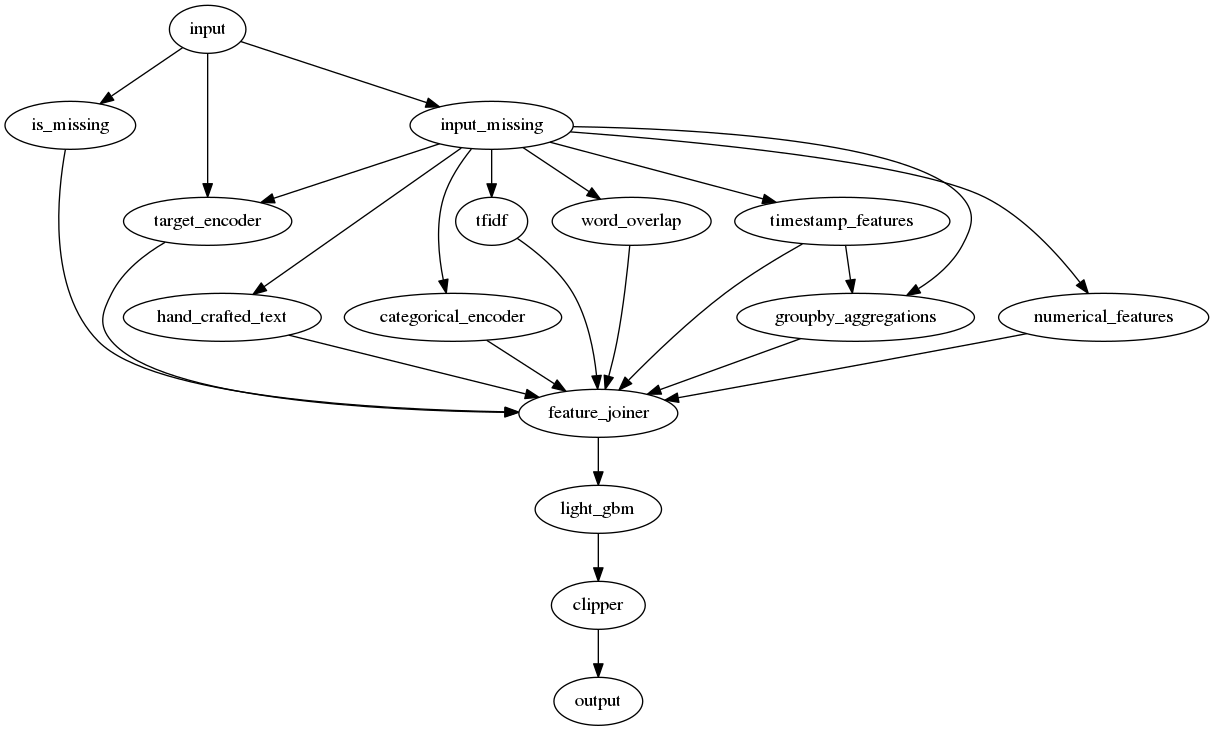

In [6]:
main(cfg.SOLUTION_CONFIG, train_mode=False)

## Feature Extraction
* price features - for now just the price value
* target encoded features - likelihood encoding for categorical features
* groupby aggregations - features calculated based on aggregated categories

```python
    'groupby_aggregation': {'groupby_aggregations': [
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['user_id'], 'select': 'parent_category_name', 'agg': 'nunique'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['region'], 'select': 'parent_category_name', 'agg': 'count'},
        {'groupby': ['city'], 'select': 'parent_category_name', 'agg': 'count'},
    ]},
```

## Models
* lightgbm with the following parameters

```yaml
  lgbm_random_search_runs: 0
  lgbm__boosting_type: 'gbdt'
  lgbm__objective: regression
  lgbm__metric: RMSE
  lgbm__number_boosting_rounds: 300
  lgbm__early_stopping_rounds: 30
  lgbm__learning_rate: 0.05
  lgbm__num_leaves: 77
  lgbm__max_depth: 11
  lgbm__min_child_samples: 44
  lgbm__max_bin: 379
  lgbm__subsample: 0.82
  lgbm__subsample_freq: 2
  lgbm__colsample_bytree: 0.27
  lgbm__min_child_weight: 4
  lgbm__reg_lambda: 0.0
  lgbm__reg_alpha: 0.1
```

## Result Exploration

In [ ]:
prediction_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'evaluation_predictions.csv')
evaluation_predictions =  pd.read_csv(prediction_filepath)

In [ ]:
top_n = 100
best_predictions = evaluation_predictions.sort_values('score', ascending=True)[:top_n]
worst_predictions = evaluation_predictions.sort_values('score', ascending=False)[:top_n]

In [ ]:
worst_predictions.head(3)

## Model exploration

In [ ]:
model_filepath = os.path.join(EXPERIMENT_DIR, 'solution_2', 'transformers','light_gbm')
light_gbm_model = joblib.load(model_filepath)

### Learning Curve

In [ ]:
ax = lgb.plot_metric(light_gbm_model['evals_result'], metric='rmse')
plt.show()

### Feature Importance

In [ ]:
ax = lgb.plot_importance(light_gbm_model['estimator'], max_num_features=20)
plt.show()